![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/3.SparkNLP_Pretrained_Models.ipynb)

# 3. Spark NLP Pretrained Models

Spark NLP offers the following pre-trained models in 26 languages and all you need to do is to load the pre-trained model into your disk by specifying the model name and then configuring the model parameters as per your use case and dataset. Then you will not need to worry about training a new model from scratch and will be able to enjoy the pre-trained SOTA algorithms directly applied to your own data with transform().

In the official documentation, you can find detailed information regarding how these models are trained by using which algorithms and datasets.

https://github.com/JohnSnowLabs/spark-nlp-models


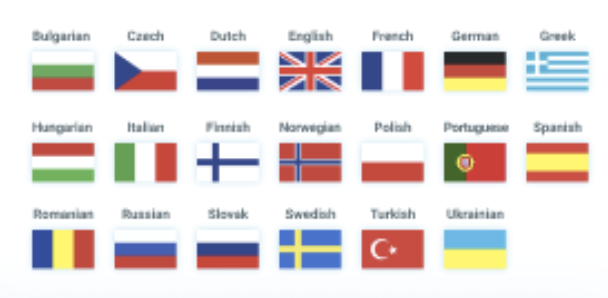

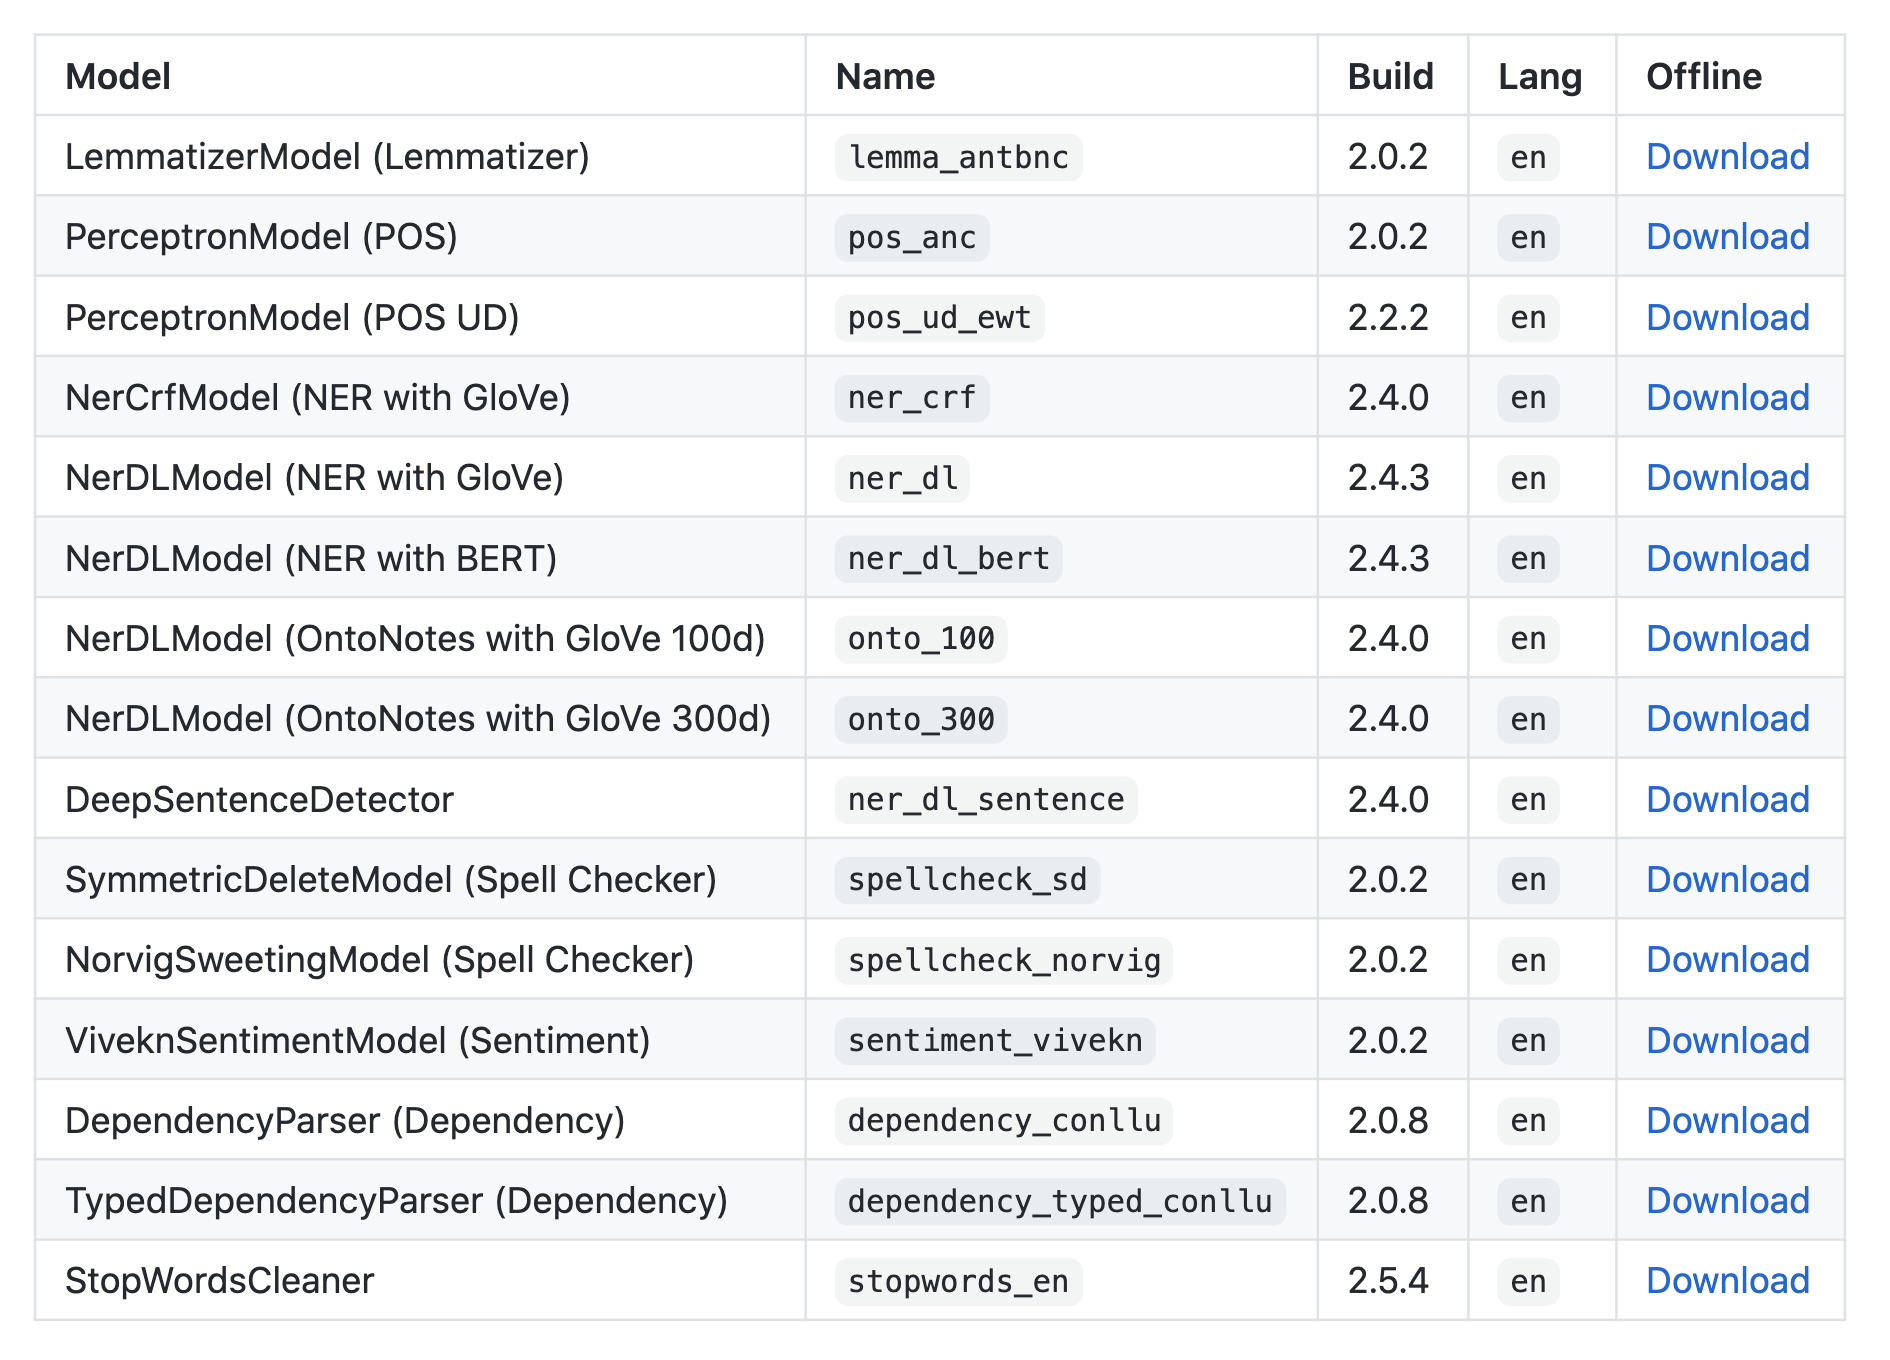

## Colab Setup

In [1]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4
! pip install --ignore-installed -q spark-nlp==2.5.4

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
     |████████████████████████████████| 215.7MB 63kB/s 
     |████████████████████████████████| 204kB 47.8MB/s 
     |████████████████████████████████| 133kB 2.7MB/s 


In [2]:
import sparknlp

spark = sparknlp.start()

from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 2.5.4
Apache Spark version: 2.4.4


## LemmatizerModel

In [17]:
!wget -q -O news_category_test.csv https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/classifier-dl/news_Category/news_category_test.csv

In [18]:
import pyspark.sql.functions as F

news_df = spark.read\
                .option("header", "true")\
                .csv("news_category_test.csv")\
                .withColumnRenamed("description", "text")

news_df.show(truncate=50)

+--------+--------------------------------------------------+
|category|                                              text|
+--------+--------------------------------------------------+
|Business|Unions representing workers at Turner   Newall ...|
|Sci/Tech| TORONTO, Canada    A second team of rocketeers...|
|Sci/Tech| A company founded by a chemistry researcher at...|
|Sci/Tech| It's barely dawn when Mike Fitzpatrick starts ...|
|Sci/Tech| Southern California's smog fighting agency wen...|
|Sci/Tech|"The British Department for Education and Skill...|
|Sci/Tech|"confessed author of the Netsky and Sasser viru...|
|Sci/Tech|\\FOAF/LOAF  and bloom filters have a lot of in...|
|Sci/Tech|"Wiltshire Police warns about ""phishing"" afte...|
|Sci/Tech|In its first two years, the UK's dedicated card...|
|Sci/Tech| A group of technology companies  including Tex...|
|Sci/Tech| Apple Computer Inc.&lt;AAPL.O&gt; on  Tuesday ...|
|Sci/Tech| Free Record Shop, a Dutch music  retail chain,...|
|Sci/Tec

In [ ]:
lemmatizer = LemmatizerModel.pretrained('lemma_antbnc', 'en') \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \


'''
lemmatizer = Lemmatizer() \
    .setInputCols(["token"]) \
    .setOutputCol("lemma") \
    .setDictionary("./AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->")
'''

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


'\nlemmatizer = Lemmatizer()     .setInputCols(["token"])     .setOutputCol("lemma")     .setDictionary("./AntBNC_lemmas_ver_001.txt", value_delimiter ="\t", key_delimiter = "->")\n'

In [ ]:
!cd ~/cache_pretrained && ls -l


total 4
drwxr-xr-x 4 root root 4096 Jul 26 20:33 lemma_antbnc_en_2.0.2_2.4_1556480454569


In [ ]:
from pyspark.ml import Pipeline

documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

stemmer = Stemmer() \
    .setInputCols(["token"]) \
    .setOutputCol("stem")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


In [ ]:
result = pipelineModel.transform(news_df)

result.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|                text|            document|               token|                stem|               lemma|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Business|Unions representi...|[[document, 0, 12...|[[token, 0, 5, Un...|[[token, 0, 5, un...|[[token, 0, 5, Un...|
|Sci/Tech| TORONTO, Canada ...|[[document, 0, 22...|[[token, 1, 7, TO...|[[token, 1, 7, to...|[[token, 1, 7, TO...|
|Sci/Tech| A company founde...|[[document, 0, 20...|[[token, 1, 1, A,...|[[token, 1, 1, a,...|[[token, 1, 1, A,...|
|Sci/Tech| It's barely dawn...|[[document, 0, 26...|[[token, 1, 4, It...|[[token, 1, 4, it...|[[token, 1, 4, It...|
|Sci/Tech| Southern Califor...|[[document, 0, 17...|[[token, 1, 8, So...|[[token, 1, 8, so...|[[token, 1, 8, So...|
+--------+--------------------+--------------------+--------------------

In [ ]:
result.select('token.result','lemma.result').show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Unions, representing, workers, at, Turner, Newall, say, they, are, ', disappointed, ', after, ta...|[Unions, represent, worker, at, Turner, Newall, say, they, be, ', disappointed, ', after, talk, w...|
|[TORONTO, ,, Canada, A, second, team, of, rocketeers, competing, for, the, #36;10, million, Ansar...|[TORONTO, ,, Canada, A, second, team, of, rocketeer, compete, for, the, #36;10, mi

## PerceptronModel (POS - Part of speech tags)

In [ ]:
import pandas as pd

pos_df= pd.read_html('https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html')

pos_df[0]

,0,1,2
0,Number,Tag,Description
1,1.,CC,Coordinating conjunction
2,2.,CD,Cardinal number
3,3.,DT,Determiner
4,4.,EX,Existential there
5,5.,FW,Foreign word
6,6.,IN,Preposition or subordinating conjunction
7,7.,JJ,Adjective
8,8.,JJR,"Adjective, comparative"
9,9.,JJS,"Adjective, superlative"


In [ ]:
pos = PerceptronModel.pretrained("pos_anc", 'en')\
      .setInputCols("document", "token")\
      .setOutputCol("pos")

pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]


In [ ]:
!cd ~/cache_pretrained && ls -l


total 8
drwxr-xr-x 4 root root 4096 Jul 26 20:33 lemma_antbnc_en_2.0.2_2.4_1556480454569
drwxr-xr-x 4 root root 4096 Jul 26 20:34 pos_anc_en_2.0.2_2.4_1556659930154


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer,
 pos
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


In [ ]:
result = pipelineModel.transform(news_df)

result.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|                text|            document|               token|                stem|               lemma|                 pos|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Business|Unions representi...|[[document, 0, 12...|[[token, 0, 5, Un...|[[token, 0, 5, un...|[[token, 0, 5, Un...|[[pos, 0, 5, NNP,...|
|Sci/Tech| TORONTO, Canada ...|[[document, 0, 22...|[[token, 1, 7, TO...|[[token, 1, 7, to...|[[token, 1, 7, TO...|[[pos, 1, 7, NNP,...|
|Sci/Tech| A company founde...|[[document, 0, 20...|[[token, 1, 1, A,...|[[token, 1, 1, a,...|[[token, 1, 1, A,...|[[pos, 1, 1, DT, ...|
|Sci/Tech| It's barely dawn...|[[document, 0, 26...|[[token, 1, 4, It...|[[token, 1, 4, it...|[[token, 1, 4, It...|[[pos, 1, 4, NNP,...|
|Sci/Tech| Southern Califor...|[[document

In [ ]:
result.select('token.result','pos.result').show(5, truncate=100)

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                              result|                                                                                              result|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|[Unions, representing, workers, at, Turner, Newall, say, they, are, ', disappointed, ', after, ta...|    [NNP, VBG, NNS, IN, NNP, NNP, VBP, PRP, VBP, POS, JJ, POS, IN, NNS, IN, NN, NN, NN, NNP, NNP, .]|
|[TORONTO, ,, Canada, A, second, team, of, rocketeers, competing, for, the, #36;10, million, Ansar...|[NNP, ,, NNP, DT, JJ, NN, IN, NNS, VBG, IN, DT, NN, CD, NNP, NNP, NNP, ,, DT, NN, 

In [ ]:
# applying this pipeline to top 100 rows and then converting to Pandas

result = pipelineModel.transform(news_df.limit(100))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'token.begin', 'token.end', 'stem.result',  'lemma.result', 'pos.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']").alias("stem"),
        F.expr("cols['4']").alias("lemma"),
        F.expr("cols['5']").alias("pos")).toPandas()

result_df.head(10) 

,token,begin,end,stem,lemma,pos
0,Unions,0,5,union,Unions,NNP
1,representing,7,18,repres,represent,VBG
2,workers,20,26,worker,worker,NNS
3,at,28,29,at,at,IN
4,Turner,31,36,turner,Turner,NNP
5,Newall,40,45,newal,Newall,NNP
6,say,47,49,sai,say,VBP
7,they,51,54,thei,they,PRP
8,are,56,58,ar,be,VBP
9,',60,60,',',POS


In [ ]:
# same in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.annotate('Unions representing workers at Turner   Newall say they are disappointed after talks with stricken parent firm Federal Mogul.')

list(zip(light_result['token'], light_result['stem'], light_result['lemma'], light_result['pos']))

[('Unions', 'union', 'Unions', 'NNP'),
 ('representing', 'repres', 'represent', 'VBG'),
 ('workers', 'worker', 'worker', 'NNS'),
 ('at', 'at', 'at', 'IN'),
 ('Turner', 'turner', 'Turner', 'NNP'),
 ('Newall', 'newal', 'Newall', 'NNP'),
 ('say', 'sai', 'say', 'VBP'),
 ('they', 'thei', 'they', 'PRP'),
 ('are', 'ar', 'be', 'VBP'),
 ('disappointed', 'disappoint', 'disappointed', 'VBN'),
 ('after', 'after', 'after', 'IN'),
 ('talks', 'talk', 'talk', 'NNS'),
 ('with', 'with', 'with', 'IN'),
 ('stricken', 'stricken', 'stricken', 'NN'),
 ('parent', 'parent', 'parent', 'NN'),
 ('firm', 'firm', 'firm', 'NN'),
 ('Federal', 'feder', 'Federal', 'NNP'),
 ('Mogul', 'mogul', 'Mogul', 'NNP'),
 ('.', '.', '.', '.')]

## Chunker

Meaningful phrase matching

This annotator matches a pattern of part-of-speech tags in order to return meaningful phrases from document

Output type: Chunk

Input types: Document, POS

Functions:

`setRegexParsers(patterns)`: A list of regex patterns to match chunks, for example: Array(“‹DT›?‹JJ›*‹NN›

`addRegexParser(patterns)`: adds a pattern to the current list of chunk patterns, for example: “‹DT›?‹JJ›*‹NN›”

In [ ]:
# applying POS chunker to find a custom pattern

chunker = Chunker()\
    .setInputCols(["document", "pos"])\
    .setOutputCol("chunk")\
    .setRegexParsers(["<NNP>+", "<DT>?<JJ>*<NN>"])

# NNP: Proper Noun
# NN: COmmon Noun
# DT: Determinator (e.g. the)
# JJ: Adjective

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer,
 pos,
 chunker
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df.limit(100))

result.show(5)

+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|category|                text|            document|               token|                stem|               lemma|                 pos|               chunk|
+--------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Business|Unions representi...|[[document, 0, 12...|[[token, 0, 5, Un...|[[token, 0, 5, un...|[[token, 0, 5, Un...|[[pos, 0, 5, NNP,...|[[chunk, 0, 5, Un...|
|Sci/Tech| TORONTO, Canada ...|[[document, 0, 22...|[[token, 1, 7, TO...|[[token, 1, 7, to...|[[token, 1, 7, TO...|[[pos, 1, 7, NNP,...|[[chunk, 1, 7, TO...|
|Sci/Tech| A company founde...|[[document, 0, 20...|[[token, 1, 1, A,...|[[token, 1, 1, a,...|[[token, 1, 1, A,...|[[pos, 1, 1, DT, ...|[[chunk, 52, 61, ...|
|Sci/Tech| It's barely dawn...|[[document, 0, 26...|

In [ ]:

result_df = result.select(F.explode(F.arrays_zip('chunk.result', 'chunk.begin',  'chunk.end')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end")).toPandas()

result_df.head(10)

,chunk,begin,end
0,Unions,0,5
1,Turner Newall,31,45
2,Federal Mogul,113,125
3,stricken,92,99
4,parent,101,106
5,firm,108,111
6,TORONTO,1,7
7,Canada,10,15
8,Ansari X Prize,82,95
9,A second team,20,32


## Dependency Parser



In [ ]:
dep_parser = DependencyParserModel.pretrained('dependency_conllu')\
        .setInputCols(["document", "pos", "token"])\
        .setOutputCol("dependency")

dependency_conllu download started this may take some time.
Approximate size to download 16.6 MB
[OK!]


In [ ]:
typed_dep_parser = TypedDependencyParserModel.pretrained('dependency_typed_conllu')\
        .setInputCols(["token", "pos", "dependency"])\
        .setOutputCol("dependency_type")

dependency_typed_conllu download started this may take some time.
Approximate size to download 257.4 KB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer,
 pos,
 dep_parser,
 typed_dep_parser
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df.limit(100))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'token.begin',  'token.end', 'dependency.result', 'dependency_type.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']").alias("begin"),
        F.expr("cols['2']").alias("end"),
        F.expr("cols['3']").alias("dependency"),
        F.expr("cols['4']").alias("dependency_type")).toPandas()

result_df.head(10)

,chunk,begin,end,dependency,dependency_type
0,Unions,0,5,ROOT,root
1,representing,7,18,workers,amod
2,workers,20,26,Unions,flat
3,at,28,29,Turner,case
4,Turner,31,36,workers,flat
5,Newall,40,45,say,nsubj
6,say,47,49,Unions,parataxis
7,they,51,54,disappointed,nsubj
8,are,56,58,disappointed,nsubj
9,',60,60,disappointed,case


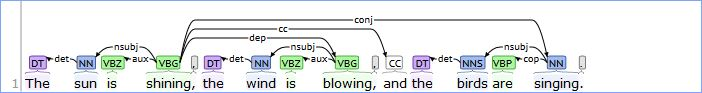

## SpellChecker

### Norvig Spell Checker

This annotator retrieves tokens and makes corrections automatically if not found in an English dictionary

In [ ]:
spell_checker_norvig = NorvigSweetingModel.pretrained('spellcheck_norvig')\
        .setInputCols("token")\
        .setOutputCol("corrected")


spellcheck_norvig download started this may take some time.
Approximate size to download 4.2 MB
[OK!]


In [ ]:
from pyspark.sql.types import StringType

text_list = ['Peter Parker is a nice persn and lives in New York.', 'Bruce Wayne is also a nice guy and lives in Gotham City.']

spark_df = spark.createDataFrame(text_list, StringType()).toDF("text")

spark_df.show(truncate=80)

+--------------------------------------------------------+
|                                                    text|
+--------------------------------------------------------+
|     Peter Parker is a nice persn and lives in New York.|
|Bruce Wayne is also a nice guy and lives in Gotham City.|
+--------------------------------------------------------+



In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 stemmer,
 lemmatizer,
 pos,
 spell_checker_norvig
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(spark_df)


In [ ]:
from pyspark.sql import functions as F

result_df = result.select(F.explode(F.arrays_zip('token.result', 'corrected.result', 'stem.result',  'lemma.result', 'pos.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("corrected"),
        F.expr("cols['2']").alias("stem"),
        F.expr("cols['3']").alias("lemma"),
        F.expr("cols['4']").alias("pos")).toPandas()

result_df.head(10)

,token,corrected,stem,lemma,pos
0,Peter,Peter,peter,Peter,NNP
1,Parker,Parker,parker,Parker,NNP
2,is,is,i,be,VBZ
3,a,a,a,a,DT
4,nice,nice,nice,nice,JJ
5,persn,person,persn,persn,NN
6,and,and,and,and,CC
7,lives,lives,live,life,NNS
8,in,in,in,in,IN
9,New,New,new,New,NNP


In [ ]:
# same in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.annotate('The patint has pain and headace')

list(zip(light_result['token'], light_result['corrected']))


[('The', 'The'),
 ('patint', 'patient'),
 ('has', 'has'),
 ('pain', 'pain'),
 ('and', 'and'),
 ('headace', 'headache')]

### Context SpellChecker

The idea for this annotator is to have a flexible, configurable and "re-usable by parts" model.

Flexibility is the ability to accommodate different use cases for spell checking like OCR text, keyboard-input text, ASR text, and general spelling problems due to orthographic errors.

We say this is a configurable annotator, as you can adapt it yourself to different use cases avoiding re-training as much as possible.

Spell Checking at three levels: The final ranking of a correction sequence is affected by three things,

Different correction candidates for each word - **word level**.

The surrounding text of each word, i.e. it's context - **sentence level**.

The relative cost of different correction candidates according to the edit operations at the character level it requires - **subword level**.

In [ ]:

spellModel = ContextSpellCheckerModel\
    .pretrained('spellcheck_dl')\
    .setInputCols("token")\
    .setOutputCol("checked")

finisher = Finisher()\
    .setInputCols("checked")

pipeline = Pipeline(
    stages = [
    documentAssembler,
    tokenizer,
    spellModel,
    finisher
  ])

empty_ds = spark.createDataFrame([[""]]).toDF("text")

sc_model = pipeline.fit(empty_ds)
lp = LightPipeline(sc_model)

spellcheck_dl download started this may take some time.
Approximate size to download 112 MB
[OK!]


In [ ]:
lp.annotate("Plaese alliow me tao introdduce myhelf, I am a man of waelth und tiaste")


{'checked': ['Please',
  'allow',
  'me',
  'to',
  'introduce',
  'myself',
  ',',
  'I',
  'am',
  'a',
  'man',
  'of',
  'wealth',
  'and',
  'taste']}

In [ ]:
examples = ['We will go to swimming if the ueather is nice.',\
    "I have a black ueather jacket, so nice.",\
    "I introduce you to my sister, she is called ueather."]

spark_df = spark.createDataFrame(examples, StringType()).toDF("text")

results = sc_model.transform(spark_df)

results.show(truncate=False)


+----------------------------------------------------+-------------------------------------------------------------------+
|text                                                |finished_checked                                                   |
+----------------------------------------------------+-------------------------------------------------------------------+
|We will go to swimming if the ueather is nice.      |[We, will, go, to, swimming, if, the, weather, is, nice, .]        |
|I have a black ueather jacket, so nice.             |[I, have, a, black, leather, jacket, ,, so, nice, .]               |
|I introduce you to my sister, she is called ueather.|[I, introduce, you, to, my, sister, ,, she, is, called, Heather, .]|
+----------------------------------------------------+-------------------------------------------------------------------+



## Language Detector

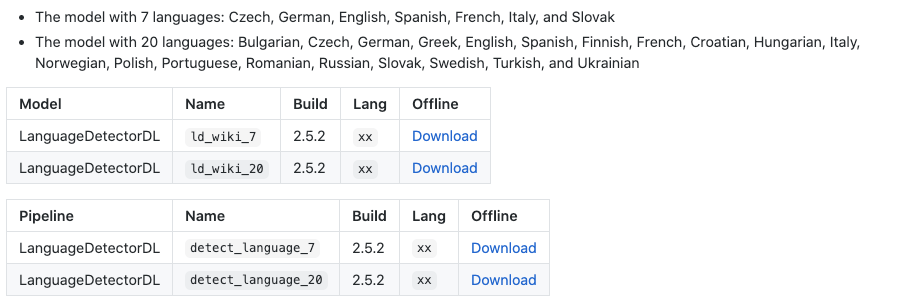

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")


languageDetector = LanguageDetectorDL.pretrained('ld_wiki_20', 'xx')\
      .setInputCols("document")\
      .setOutputCol("language")\
      .setThreshold(0.5)\
      .setCoalesceSentences(True)

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 languageDetector
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


ld_wiki_20 download started this may take some time.
Approximate size to download 3 MB
[OK!]


In [ ]:
light_model = LightPipeline(pipelineModel)


In [ ]:
text_en = "William Henry Gates III (born October 28, 1955) is an American business magnate, software developer, investor, and philanthropist. He is best known as the co-founder of Microsoft Corporation. During his career at Microsoft, Gates held the positions of chairman, chief executive officer (CEO), president and chief software architect, while also being the largest individual shareholder until May 2014."

text_de = 'Als Sebastian Thrun 2007 bei Google anfing, an selbstfahrenden Autos zu arbeiten, nahmen ihn nur wenige Leute außerhalb des Unternehmens ernst.'

text_es = "La historia del procesamiento del lenguaje natural generalmente comenzó en la década de 1950, aunque se puede encontrar trabajo de períodos anteriores. En 1950, Alan Turing publicó un artículo titulado 'Maquinaria de computación e inteligencia' que proponía lo que ahora se llama la prueba de Turing como criterio de inteligencia"

text_it = "Geoffrey Everest Hinton è uno psicologo cognitivo e uno scienziato informatico canadese inglese, noto soprattutto per il suo lavoro sulle reti neurali artificiali. Dal 2013 divide il suo tempo lavorando per Google e l'Università di Toronto. Nel 2017 è stato cofondatore ed è diventato Chief Scientific Advisor del Vector Institute di Toronto."



In [ ]:
light_model.annotate(text_de)['language']

['de']

In [ ]:
light_model.fullAnnotate(text_es)[0]['language']

[Annotation(language, 0, 328, es, {'hr': '3.0852183E-7', 'fr': '2.3359653E-5', 'uk': '3.7443638E-7', 'pt': '3.811586E-5', 'cs': '7.113755E-6', 'el': '1.1423608E-5', 'it': '3.415775E-5', 'bg': '1.9164734E-6', 'de': '3.5754451E-6', 'ru': '1.998705E-5', 'sv': '1.3846361E-6', 'tr': '3.8109105E-5', 'en': '4.0024934E-5', 'sk': '2.7228594E-5', 'es': '0.9997111', 'fi': '6.467608E-7', 'ro': '6.1194587E-6', 'no': '2.988667E-6', 'sentence': '0', 'hu': '1.4394581E-5', 'pl': '1.7670265E-5'})]

## Embeddings

### Word Embeddings (Glove)

In [ ]:
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")
    

glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 glove_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df.limit(10))


In [ ]:
result.select('embeddings.embeddings').take(1)

[Row(embeddings=[[0.7186499834060669, 0.8075399994850159, -1.1786999702453613, 0.271450012922287, -0.48833000659942627, -0.1893800050020218, -1.1789000034332275, 0.1783600002527237, -0.21995000541210175, -0.7215999960899353, -0.5354200005531311, -0.7507500052452087, 0.41176000237464905, 0.18951000273227692, -0.5093500018119812, -0.735010027885437, 0.33823999762535095, 0.3451400101184845, -0.16735999286174774, 0.130390003323555, 1.1055999994277954, 0.5508400201797485, -0.01406800001859665, -0.5322800278663635, -0.23598000407218933, -1.0496000051498413, -0.6549199819564819, -0.17997999489307404, 0.10341999679803848, -0.315530002117157, 0.31481000781059265, 0.8438799977302551, 0.305400013923645, -1.158400058746338, 0.047777000814676285, -0.04945499822497368, 0.7908999919891357, -0.22619999945163727, -0.6294800043106079, 0.3116999864578247, -0.7399600148200989, 0.1283400058746338, 0.10723999887704849, 0.3257099986076355, -0.2687300145626068, -0.70169997215271, 0.16669000685214996, 0.330889

In [ ]:
result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("embeddings"))

result_df.show(10, truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                          embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[0.71865, 0.80754, -1.1787, 0.27145, -0.48833, -0.18938, -1.1789, 0.17836, -0.21995, -0.7216, -0....|
|representing|[0.25671, 0.30035, -0.18006, 0.46666, 0.98501, 0.2321, -0.34959, 0.26997, -0.99667, -0.43404, -0....|
|     workers|[0.50592, 0.71717, -0.67236, -0.32112, -0.58285, -0.47977, -0.50243, 0.60594, 0.25709, 0.03974, -...|
|          at|[0.1766, 0.093851, 0.24351, 0.44313, -0.39037, 0.12524, -0.19918, 0.59855, -0.82035, 0.28006, 0.5...|
|      Turner|[0.51634, -0.37186, -0.21776, -1.0115, 0.4014, -0.4841, 0.36274, -0.2952, -0.42258, -0.62844, 0.6...|
|      Newall|[-0.38857, -1.1449, -0.41737, -0.31969, -0.16546, -0.7044,

#### Using your own Word embeddings in Spark NLP

In [ ]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.nl.300.vec.gz

--2020-07-26 23:24:15--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.nl.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 104.22.75.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1255218462 (1.2G) [binary/octet-stream]
Saving to: ‘cc.nl.300.vec.gz’

cc.nl.300.vec.gz    100%[===================>]   1.17G  12.1MB/s    in 1m 41s  

2020-07-26 23:25:57 (11.9 MB/s) - ‘cc.nl.300.vec.gz’ saved [1255218462/1255218462]



In [ ]:
!gunzip cc.nl.300.vec.gz

In [ ]:
custom_embeddings = WordEmbeddings()\
  .setInputCols(["document", "token"])\
  .setOutputCol("my_embeddings")\
  .setStoragePath('cc.nl.300.vec', "TEXT")\
  .setDimension(300)

custom_embeddings_model = custom_embeddings.fit(result.limit(10))# any df would be fine as long as it had document and token columns thru Spark NLP

In [ ]:
custom_embeddings_model.transform(result.limit(10)).select('my_embeddings.embeddings').take(1)

### Elmo Embeddings

Computes contextualized word representations using character-based word representations and bidirectional LSTMs.

It can work with 4 different pooling layer options: `word_emb`, 
`lstm_outputs1`, `lstm_outputs2`, or `elmo`

In [ ]:
elmo_embeddings = ElmoEmbeddings.pretrained('elmo')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")\
          .setPoolingLayer('elmo')# default --> elmo
    

elmo download started this may take some time.
Approximate size to download 334.1 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 elmo_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("elmo_embeddings"))

result_df.show(truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                     elmo_embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[0.5389476, 0.4226915, -0.16224553, -0.1128005, -0.12524837, -0.28185326, 0.12341033, -0.22033125...|
|representing|[0.1591705, 0.95000935, -0.12492801, 0.9341251, 0.5854504, 0.7605221, -0.30143818, -0.3193327, -0...|
|     workers|[0.082813635, -0.17253807, -0.73114246, 0.56554866, 0.36294985, -0.42002633, 0.66982335, -0.71128...|
|          at|[-0.11999596, 0.01299414, -0.078183725, 0.037628517, -0.268691, 0.13629477, -0.27565888, 0.343611...|
|      Turner|[0.32819325, -0.11992816, 0.15701114, 0.560922, -0.2836563, -0.1923972, 0.04214704, 0.5058229, -0...|
|      Newall|[-0.17683865, -0.5143349, -0.45629728, -7.754117E-4, -0.35

### Bert Embeddings

BERT (Bidirectional Encoder Representations from Transformers) provides dense vector representations for natural language by using a deep, pre-trained neural network with the Transformer architecture

It can work with 3 different pooling layer options: `0`, 
`-1`, or `-2`

In [3]:
bert_embeddings = BertEmbeddings.pretrained('bert_base_uncased')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")\
          .setPoolingLayer(0)

bert_base_uncased download started this may take some time.
Approximate size to download 392.5 MB
[OK!]


In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 bert_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("bert_embeddings"))

result_df.show(truncate=100)

+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                     bert_embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[0.3423483, -0.7621089, -0.95610934, -0.9080744, 0.03278944, -0.19068101, 0.06841645, 0.8715485, ...|
|representing|[-0.6609322, 0.36830586, -0.04385671, -0.062400907, -0.21250877, -0.3625311, -0.13388896, -9.9757...|
|     workers|[-0.49138808, -0.0533655, -1.1493174, -0.6050249, -0.7109844, 0.20254612, 0.53452104, -0.6757567,...|
|          at|[-0.59642524, 0.13935125, 0.09018701, -0.6268516, -0.75282824, 0.16119936, 0.10998525, 0.6566241,...|
|      Turner|[0.87067986, 0.6809796, 0.7334639, 0.03486839, 0.07190508, 0.5168021, 0.18955632, 0.76651955, 0.5...|
|      Newall|[0.17950639, -0.34025913, 0.25570604, 0.21317199, -0.33208

### Albert Embeddings

Computes contextualized word representations using “A Lite” implementation of BERT algorithm by applying parameter-reduction techniques



In [ ]:
albert_embeddings = AlbertEmbeddings.pretrained('albert_base_uncased')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 albert_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("bert_embeddings"))

result_df.show(truncate=100)

albert_base_uncased download started this may take some time.
Approximate size to download 42.7 MB
[OK!]
+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                     bert_embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[-1.6669579, -1.1295664, 1.5798393, -1.1321464, 0.6854725, -0.26543844, -1.0202373, 0.16552903, 0...|
|representing|[-1.2177894, 0.03552811, -1.7176481, -1.9149119, 1.0310044, -0.31122386, -0.40940276, 0.20491472,...|
|     workers|[-1.2497592, -0.09412593, 1.1587988, -0.5631165, 1.1273519, 0.37279162, -1.3649018, -0.9526753, 0...|
|          at|[-1.1716074, -0.004132867, -0.33128285, -1.5644011, 0.38777137, 0.62366825, 2.180558, -0.43693462...|
|      Turner|[-0.44532847, -1.0916773, 1.7819966, -0.70549357, 0.21324196, 0.89941

### XlnetEmbeddings

Computes contextualized word representations using combination of Autoregressive Language Model and Permutation Language Model

In [ ]:
xlnet_embeddings = XlnetEmbeddings.pretrained('xlnet_base_cased')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 xlnet_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("bert_embeddings"))

result_df.show(truncate=100)

xlnet_base_cased download started this may take some time.
Approximate size to download 415.8 MB
[OK!]
+------------+----------------------------------------------------------------------------------------------------+
|       token|                                                                                     bert_embeddings|
+------------+----------------------------------------------------------------------------------------------------+
|      Unions|[-0.85942656, -0.5573996, 1.3173034, -1.146939, -0.08702205, 1.1876537, -0.08872176, -1.0941851, ...|
|representing|[-0.12686324, -1.5573617, 1.1400528, 0.79628694, 1.923844, -1.847331, -0.5191322, -0.66512793, -0...|
|     workers|[-1.185917, -0.84681135, 1.6014696, -0.87218857, 0.7529939, 0.46347773, 1.2401333, -0.8114534, -1...|
|          at|[0.040925115, -1.0951933, -1.742269, 0.015328597, -1.0510299, -0.673334, 1.2163577, -1.8911505, 0...|
|      Turner|[0.18314219, 0.89316785, 0.51512134, 0.22869489, 1.1063788, -0.11106314

### Chunk Embeddings

This annotator utilizes `WordEmbeddings` or `BertEmbeddings` to generate chunk embeddings from either `TextMatcher`, `RegexMatcher`, `Chunker`, `NGramGenerator`, or `NerConverter` outputs.

`setPoolingStrategy`: Choose how you would like to aggregate Word Embeddings to Sentence Embeddings: `AVERAGE` or `SUM`

In [ ]:
news_df.take(3)

[Row(category='Business', text="Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."),
 Row(category='Sci/Tech', text=' TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for privately funded suborbital space flight, has officially announced the first launch date for its manned rocket.'),
 Row(category='Sci/Tech', text=' A company founded by a chemistry researcher at the University of Louisville won a grant to develop a method of producing better peptides, which are short chains of amino acids, the building blocks of proteins.')]

In [ ]:
entities = ['parent firm', 'economy', 'amino acids']
with open ('entities.txt', 'w') as f:
    for i in entities:
        f.write(i+'\n')

entity_extractor = TextMatcher() \
    .setInputCols(["document",'token'])\
    .setOutputCol("entities")\
    .setEntities("entities.txt")\
    .setCaseSensitive(False)\
    .setEntityValue('entities')

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 entity_extractor
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df.limit(10))

result.select('entities.result').take(3)


[Row(result=['parent firm']), Row(result=[]), Row(result=['amino acids'])]

In [ ]:
chunk_embeddings = ChunkEmbeddings() \
            .setInputCols(["entities", "embeddings"]) \
            .setOutputCol("chunk_embeddings") \
            .setPoolingStrategy("AVERAGE")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 entity_extractor,
 glove_embeddings,
 chunk_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

In [ ]:
result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('entities.result', 'chunk_embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("entities"),
        F.expr("cols['1']").alias("glove_embeddings"))

result_df.show(truncate=100)

+-----------+----------------------------------------------------------------------------------------------------+
|   entities|                                                                                    glove_embeddings|
+-----------+----------------------------------------------------------------------------------------------------+
|parent firm|[0.45683652, -0.105479494, -0.34525, -0.143924, -0.192452, -0.33616, -0.22334, -0.208185, -0.3673...|
|amino acids|[-0.3861, 0.054408997, -0.287795, -0.33318, 0.375065, -0.185539, -0.330525, -0.214415, -0.73892, ...|
+-----------+----------------------------------------------------------------------------------------------------+



### UniversalSentenceEncoder

The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

In [ ]:
# no need for token columns 
use_embeddings = UniversalSentenceEncoder.pretrained('tfhub_use').\
  setInputCols(["document"]).\
  setOutputCol("sentence_embeddings")

    

In [ ]:
nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 use_embeddings
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('document.result', 'sentence_embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("USE_embeddings"))

result_df.show(truncate=100)

## Loading Models from local

In [ ]:
!cd ~/cache_pretrained && pwd

In [ ]:
!cd ~/cache_pretrained && ls -l

In [ ]:
glove_embeddings = WordEmbeddingsModel.load('/root/cache_pretrained/glove_100d_en_2.4.0_2.4_1579690104032').\
  setInputCols(["document", 'token']).\
  setOutputCol("glove_embeddings")
    

## Getting Sentence Embeddings from word embeddings

In [ ]:
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE") # or SUM


nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 glove_embeddings,
 embeddingsSentence
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('document.result', 'sentence_embeddings.embeddings')).alias("cols")) \
.select(F.expr("cols['0']").alias("document"),
        F.expr("cols['1']").alias("sentence_embeddings"))

result_df.show(truncate=100)



glove_100d download started this may take some time.
[ | ]
[OK!]
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                                            document|                                                                                 sentence_embeddings|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stric...|[0.06131713, 0.08552574, 0.1340617, -0.22403374, -0.23798925, -0.159222, -0.21079227, 0.07760903,...|
| TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize,...|[-0.05313636, 0.1

### Cosine similarity between two embeddings (sentence similarity)

In [ ]:
from scipy.spatial import distance

import numpy as np

v1 = result_df.select('sentence_embeddings').take(2)[0][0]

v2 = result_df.select('sentence_embeddings').take(2)[][0]

1 - distance.cosine(np.array(v1), np.array(v2))

0.876465618347585

In [ ]:
v2 = result_df.select('sentence_embeddings').take(2)[0][0]

1 - distance.cosine(np.array(v1), np.array(v2))

1.0

## NERDL Model

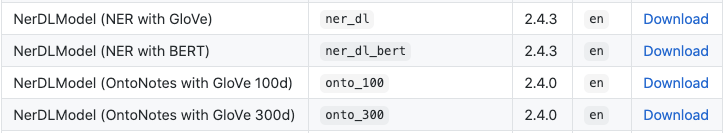

### Public NER (CoNLL 2003)


Entities

``` PERSON, LOCATION, ORGANIZATION, MISC ```

In [ ]:
public_ner = NerDLModel.pretrained("ner_dl", 'en') \
          .setInputCols(["document", "token", "embeddings"]) \
          .setOutputCol("ner")

ner_dl download started this may take some time.
Approximate size to download 13.6 MB
[OK!]


In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

# ner_dl model is trained with glove_100d. So we use the same embeddings in the pipeline
glove_embeddings = WordEmbeddingsModel.pretrained('glove_100d').\
  setInputCols(["document", 'token']).\
  setOutputCol("embeddings")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 glove_embeddings,
 public_ner
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)



+------------+---------+
|       token|ner_label|
+------------+---------+
|      Unions|        O|
|representing|        O|
|     workers|        O|
|          at|        O|
|      Turner|    B-ORG|
|      Newall|    I-ORG|
|         say|        O|
|        they|        O|
|         are|        O|
|           '|        O|
|disappointed|        O|
|           '|        O|
|       after|        O|
|       talks|        O|
|        with|        O|
|    stricken|        O|
|      parent|        O|
|        firm|        O|
|     Federal|    B-ORG|
|       Mogul|    I-ORG|
|           .|        O|
|     TORONTO|    B-LOC|
|           ,|        O|
|      Canada|    B-LOC|
|           A|        O|
|      second|        O|
|        team|        O|
|          of|        O|
|  rocketeers|        O|
|   competing|        O|
|         for|        O|
|         the|        O|
|      #36;10|        O|
|     million|        O|
|      Ansari|   B-MISC|
|           X|   I-MISC|
|       Prize|   I-MISC|


### NerDL OntoNotes 100D

Entities

``` 'CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART' ```

In [ ]:
onto_ner = NerDLModel.pretrained("onto_100", 'en') \
          .setInputCols(["document", "token", "embeddings"]) \
          .setOutputCol("ner")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 glove_embeddings,
 onto_ner
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)


onto_100 download started this may take some time.
Approximate size to download 13.5 MB
[OK!]


In [ ]:
result = pipelineModel.transform(news_df.limit(10))

result_df = result.select(F.explode(F.arrays_zip('token.result', 'ner.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ner_label"))

result_df.show(50, truncate=100)


+------------+-------------+
|       token|    ner_label|
+------------+-------------+
|      Unions|            O|
|representing|            O|
|     workers|            O|
|          at|            O|
|      Turner|        B-ORG|
|      Newall|        I-ORG|
|         say|            O|
|        they|            O|
|         are|            O|
|           '|            O|
|disappointed|            O|
|           '|            O|
|       after|            O|
|       talks|            O|
|        with|            O|
|    stricken|            O|
|      parent|            O|
|        firm|            O|
|     Federal|        B-ORG|
|       Mogul|        I-ORG|
|           .|            O|
|     TORONTO|        B-GPE|
|           ,|            O|
|      Canada|        B-GPE|
|           A|            O|
|      second|    B-ORDINAL|
|        team|            O|
|          of|            O|
|  rocketeers|            O|
|   competing|            O|
|         for|            O|
|         the|

### NER with Bert (Onto)

In [13]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = Tokenizer() \
    .setInputCols(["document"]) \
    .setOutputCol("token")

bert_embeddings = BertEmbeddings.pretrained('bert_base_cased')\
          .setInputCols(["document", "token"])\
          .setOutputCol("embeddings")

onto_ner_bert = NerDLModel.pretrained("ner_dl_bert", 'en') \
          .setInputCols(["document", "token", "embeddings"]) \
          .setOutputCol("ner")

nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 bert_embeddings,
 onto_ner_bert
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

bert_base_cased download started this may take some time.
Approximate size to download 389.2 MB
[OK!]
ner_dl_bert download started this may take some time.
Approximate size to download 15.5 MB
[OK!]


In [14]:
# fullAnnotate in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.annotate('Peter Parker is a nice persn and lives in New York. Bruce Wayne is also a nice guy and lives in Gotham City.')

list(zip(light_result['token'], light_result['ner']))

[('Peter', 'B-PER'),
 ('Parker', 'I-PER'),
 ('is', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('persn', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('New', 'B-PER'),
 ('York', 'I-PER'),
 ('.', 'O'),
 ('Bruce', 'B-PER'),
 ('Wayne', 'I-PER'),
 ('is', 'O'),
 ('also', 'O'),
 ('a', 'O'),
 ('nice', 'O'),
 ('guy', 'O'),
 ('and', 'O'),
 ('lives', 'O'),
 ('in', 'O'),
 ('Gotham', 'B-LOC'),
 ('City', 'I-LOC'),
 ('.', 'O')]

### Getting the NER chunks with NER Converter

In [19]:

ner_converter = NerConverter() \
  .setInputCols(["document", "token", "ner"]) \
  .setOutputCol("ner_chunk")


nlpPipeline = Pipeline(stages=[
 documentAssembler, 
 tokenizer,
 bert_embeddings,
 onto_ner_bert,
 ner_converter
 ])

empty_df = spark.createDataFrame([['']]).toDF("text")

pipelineModel = nlpPipeline.fit(empty_df)

result = pipelineModel.transform(news_df.limit(10))



In [20]:
result.select(F.explode(F.arrays_zip('ner_chunk.result', 'ner_chunk.metadata')).alias("cols")) \
.select(F.expr("cols['0']").alias("chunk"),
        F.expr("cols['1']['entity']").alias("ner_label")).show(truncate=False)

+---------------------+---------+
|chunk                |ner_label|
+---------------------+---------+
|Turner   Newall      |PER      |
|Federal Mogul        |ORG      |
|TORONTO              |MISC     |
|Canada               |LOC      |
|A                    |ORG      |
|Ansari X Prize       |PER      |
|University           |ORG      |
|Louisville           |MISC     |
|amino                |MISC     |
|Mike                 |PER      |
|Fitzpatrick          |LOC      |
|Southern California's|MISC     |
|emissions            |MISC     |
|The                  |ORG      |
|British              |MISC     |
|Education            |PER      |
|Skills               |PER      |
|DfES                 |ORG      |
|Music                |LOC      |
|Manifesto            |PER      |
+---------------------+---------+
only showing top 20 rows



In [34]:
# fullAnnotate in LightPipeline

light_model = LightPipeline(pipelineModel)

light_result = light_model.fullAnnotate('Peter Parker is a nice persn and lives in New York City. Bruce Wayne is also a nice guy and lives in Gotham City.')


chunks = []
entities = []

for n in light_result[0]['ner_chunk']:
        
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    
    
import pandas as pd

df = pd.DataFrame({'chunks':chunks, 'entities':entities})

df

,chunks,entities
0,Peter Parker,PER
1,New York City,LOC
2,Bruce Wayne,PER
3,Gotham City,LOC


## Highlight the entities

In [22]:
import random
from IPython.core.display import display, HTML


def get_color():
    r = lambda: random.randint(100,255)
    return '#%02X%02X%02X' % (r(),r(),r())


In [23]:
from spacy import displacy

def show_html_spacy(annotated_text, filter_labels=True):

    label_list = []
    sent_dict_list = []
    
    for n in annotated_text['ner_chunk']:

        ent = {'start': n.begin, 'end':n.end+1, 'label':n.metadata['entity'].upper()}
        
        label_list.append(n.metadata['entity'].upper())

        sent_dict_list.append(ent)
   
    document_text = [{'text':annotated_text['document'][0].result, 'ents':sent_dict_list,'title':None}]

    label_list = list(set(label_list))
                
    label_color={}
    
    for l in label_list:
        
        label_color[l]=get_color()
    
    colors = {k:label_color[k] for k in label_list}
        
    
    html_text = displacy.render(document_text, style='ent', jupyter=True, manual=True, options= {"ents": label_list, 'colors': colors})

    return html_text

In [30]:
ann_text = light_model.fullAnnotate('Peter Parker is a nice persn and lives in New York City. Bruce Wayne is also a nice guy and lives in Gotham City.')

show_html_spacy (ann_text[0])

In [31]:
def get_NER_html (annotated_text):
    
    light_data=annotated_text

    html_output=''
    
    problem_flag = False
    new_problem = []
    problem_list = []
    
    label_list = list(set([i.split('-')[1] for i in light_data['ner'] if i!='O']))
    
        
    label_color={}
    
    for l in label_list:
        
        label_color[l]=get_color()
            
    for index, this_token in enumerate(light_data['token']):

        try:
            ent = light_data['ner'][index].split('-')[1]
        except:
            ent = light_data['ner'][index]
        
       
        if ent in label_list:
            color = label_color[ent]
            html_output+='<SPAN style="background-color: {}">'.format(color) + this_token + " </SPAN>"
        else:
            html_output+=this_token + " "
        

    html_output += '</div>'
    html_output += '<div>Color codes:'
    

    for l in label_list:
        
        html_output += '<SPAN style="background-color: {}">{}</SPAN>, '.format(label_color[l],l)
   
    
    return display(HTML(html_output))
    



In [33]:
ann_text = light_model.annotate('Peter Parker is a nice persn and lives in New York City. Bruce Wayne is also a nice guy and lives in Gotham City.')

get_NER_html (ann_text)